In [1]:
import pandas as pd
import sqlite3

In [2]:
con = sqlite3.connect('../data/checking-logs.sqlite.sqlite copy')

## • run a query that gets the datetime from the pageviews table, selecting only the users and not the admins

In [121]:
query_datetime = """
SELECT  DATE(checker.timestamp) AS 'date',
        CAST(strftime('%H', checker.timestamp) AS INTEGER) AS 'hour',
        COUNT() AS commits,
        CASE
            WHEN CAST(strftime('%w', checker.timestamp) AS INTEGER) <= 5 AND NOT 0 THEN 'work_day'
                ELSE 'weekend'
        END AS 'working_day'

FROM checker

WHERE uid LIKE 'user_%'

GROUP BY date, hour
"""

commits = pd.io.sql.read_sql(query_datetime, con, parse_dates=['timestamp'])
commits



,date,hour,commits,working_day
0,2020-04-17,5,13,work_day
1,2020-04-17,11,8,work_day
2,2020-04-17,12,2,work_day
3,2020-04-18,7,1,weekend
4,2020-04-18,13,5,weekend
...,...,...,...,...
283,2020-05-21,16,4,work_day
284,2020-05-21,17,1,work_day
285,2020-05-21,18,2,work_day
286,2020-05-21,19,8,work_day


In [125]:
working_day = commits.query("working_day =='work_day'")
working_day.head(5)

,date,hour,commits,working_day
0,2020-04-17,5,13,work_day
1,2020-04-17,11,8,work_day
2,2020-04-17,12,2,work_day
13,2020-04-19,0,2,work_day
14,2020-04-19,5,2,work_day


In [123]:
weekend =  commits.query("working_day == 'weekend'")
weekend.head(5)


,date,hour,commits,working_day
3,2020-04-18,7,1,weekend
4,2020-04-18,13,5,weekend
5,2020-04-18,14,3,weekend
6,2020-04-18,15,25,weekend
7,2020-04-18,17,7,weekend


In [126]:
working_day = working_day.drop(['working_day','date'], axis=1).sort_values('hour')
working_day.rename(columns={'commits':'working_day'}, inplace=True)
working_day=working_day.groupby('hour').mean().reset_index()

working_day.head(5)

,hour,working_day
0,0,2.400000
1,1,6.000000
2,3,2.000000
3,5,5.666667
4,6,1.500000


In [127]:
weekend = weekend.drop(['working_day','date'], axis=1).sort_values('hour')
weekend.rename(columns={'commits':'weekend'},inplace=True)
weekend=weekend.groupby('hour').mean().reset_index()
weekend.head(5)

,hour,weekend
0,3,1.000000
1,7,4.666667
2,8,4.500000
3,9,2.500000
4,10,1.000000


In [128]:
hours = list(range(24))
hours = pd.DataFrame(hours, columns=['hour'])

In [129]:
plot_data = hours.merge(working_day,on='hour', how='left').merge(weekend,on='hour',how='left')

plot_data.head(30)

,hour,working_day,weekend
0,0,2.400000,NaN
1,1,6.000000,NaN
2,2,NaN,NaN
3,3,2.000000,1.000000
4,4,NaN,NaN
5,5,5.666667,NaN
6,6,1.500000,NaN
7,7,4.714286,4.666667
8,8,4.666667,4.500000
9,9,5.222222,2.500000


In [130]:
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour         24 non-null     int64  
 1   working_day  22 non-null     float64
 2   weekend      18 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 768.0 bytes


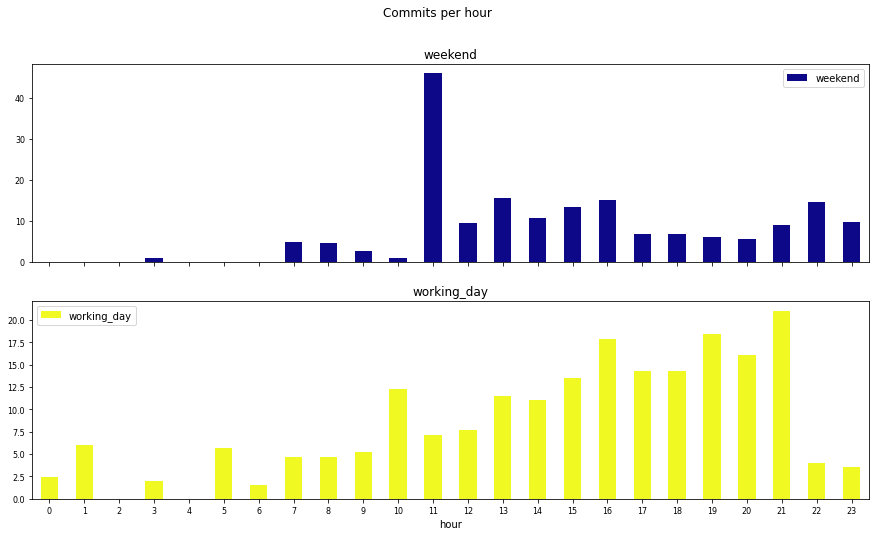

In [132]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

plot = plot_data.plot(
    y=['weekend','working_day'],
    stacked=True,
    figsize=(15, 8),
    title="Commits per hour",
    fontsize=8,
    kind='bar',
    colormap='plasma',
    subplots=True,
    x='hour',
    rot=0
)

In [ ]:
con.close()